In [1]:
from shapely.geometry import Point, LineString, MultiPoint
from shapely.ops import nearest_points, split
from datetime import datetime
import pandas as pd
import osmnx as ox
import requests
import warnings
import json

warnings.filterwarnings('ignore')

try:
    from routing_module import *
except:
    import sys
    sys.path.append('/home/happy956/')
    from routing_module import *

### 1. subway raw station

In [2]:
routesttn = pd.read_csv('data/subway/ROUTESTTN_20200831.dat', encoding='cp949', sep='|', header=None)

routesttn_cols = [
    '운행일자',
    '정산사 ID',
    '정산 지역 코드',
    '노선 ID',
    '노선 명칭',
    '정류장 순번',
    '정류장 ID',
    '정류장 명칭',
    '정류장 X 좌표',
    '정류장 Y 좌표',
    '정류장 ARS번호',
    '노선 누적 거리',
    '정류장 거리',
    '교통수단구분(B:버스,T:지하철)',
]

routesttn.columns = routesttn_cols

In [3]:
def extract_station_data(df, reverse=False):
    if reverse:
        df = df.sort_values('정류장 순번', ascending=False)
    
    station = []
    for idx in range(len(df) - 1):
        curr_row = df.iloc[idx].to_dict()
        next_row = df.iloc[idx + 1].to_dict()
        station.append({
            'start_station': curr_row['정류장 명칭'],
            'end_station': next_row['정류장 명칭'],
            'start_lat': curr_row['정류장 X 좌표'],
            'start_lon': curr_row['정류장 Y 좌표'],
            'end_lat': next_row['정류장 X 좌표'],
            'end_lon': next_row['정류장 Y 좌표'],
            'direction': 1 if reverse == False else 2
        })
    return station

In [4]:
station_cols = ['정류장 순번', '정류장 ID', '정류장 명칭', '정류장 X 좌표', '정류장 Y 좌표']
station_df = routesttn.loc[routesttn['노선 ID'] == 409, station_cols].reset_index(drop=True)

reversed_f_data = extract_station_data(station_df, reverse=False)
reversed_t_data = extract_station_data(station_df, reverse=True)
data = reversed_f_data + reversed_t_data

with open('data/subway/raw_station.json', 'w', encoding='utf8') as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

### 2. subway station

In [5]:
with open('data/subway/raw_station.json', 'r', encoding='utf8') as f:
    station_lst = json.load(f)

kimpo_station_lst = list(filter(lambda x: x['direction'] == 1, station_lst))
yongchon_station_lst = list(filter(lambda x: x['direction'] == 2, station_lst))

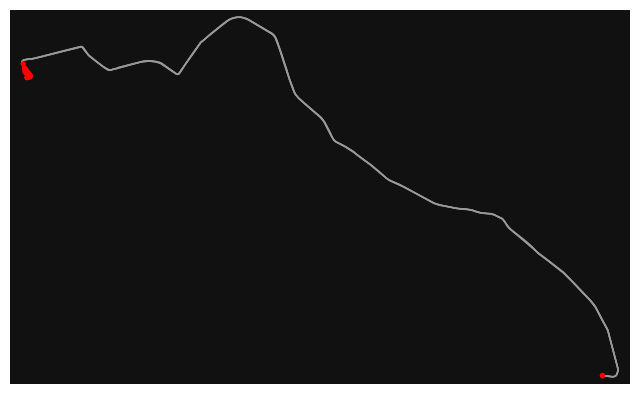

In [6]:
places = [
    '서울시, 대한민국',
    '경기도, 대한민국',
    '김포시, 경기도, 대한민국'
]

G = ox.graph_from_place(places,
                        network_type=None,
                        custom_filter='["railway"~"light_rail"]')

fig, ax = ox.plot_graph(G, node_color='r')

In [7]:
edges = ox.graph_to_gdfs(G, nodes=False)
edges = edges.reset_index()

yongchon_edge = edges[(edges['name'] == '김포 도시철도') & (edges['reversed'] == True)].iloc[0]
kimpo_edge = edges[(edges['name'] == '김포 도시철도') & (edges['reversed'] == False)].iloc[1]

In [8]:
def get_nearest_point(linestring, point):
    min_dist = 9999999999
    nearest_point = None

    for i in list(linestring.coords):
        dist = Point(i).distance(point)
        if dist < min_dist:
            min_dist = dist
            nearest_point = Point(i)
    return nearest_point

### 역 위경도 LineString 위로 보정
def update_point(edge, station_list, data):
    points = []
    for idx, station in enumerate(station_list):
        start_point = Point((station['start_lon'], station['start_lat']))
        end_point = Point((station['end_lon'], station['end_lat']))
        
        start_nearest_point = get_nearest_point(edge['geometry'], start_point)
        end_nearest_point = get_nearest_point(edge['geometry'], end_point)
        
        new_point = {**station}
        new_point['start_lon'] = list(start_nearest_point.coords)[0][0]
        new_point['start_lat'] = list(start_nearest_point.coords)[0][1]
        new_point['end_lon'] = list(end_nearest_point.coords)[0][0]
        new_point['end_lat'] = list(end_nearest_point.coords)[0][1]
        
        data.append(new_point)
        points.append(start_nearest_point)
        
        if idx == len(station_list) - 1:
            points.append(end_nearest_point)
    return data, points

In [9]:
new_station1, kimpo_points = update_point(kimpo_edge, kimpo_station_lst, [])
new_station2, yongchon_points = update_point(yongchon_edge, yongchon_station_lst, new_station1)

with open('data/subway/subway_station.json', 'w', encoding='utf8') as f:
    json.dump(new_station2, f, indent=4, ensure_ascii=False)

### 3. subway path

In [10]:
### LineString 분리
yongchon_multi_point = MultiPoint(yongchon_points)
kimpo_multi_point = MultiPoint(kimpo_points)

kimpo_splited_linestring = split(kimpo_edge['geometry'], kimpo_multi_point)
kimpo_splited_linestring = list(kimpo_splited_linestring)[1:-1]

yongchon_splited_linestring = split(yongchon_edge['geometry'], yongchon_multi_point)
yongchon_splited_linestring = list(yongchon_splited_linestring)[1:-1]

In [11]:
from folium import Map, PolyLine

m = Map(location=[36, 127], zoom_start=12)

for i in yongchon_splited_linestring:
    PolyLine(locations=list(map(lambda x: x[::-1], list(i.coords))), color='blue').add_to(m)
    
for i in kimpo_splited_linestring:
    PolyLine(locations=list(map(lambda x: x[::-1], list(i.coords))), color='red').add_to(m)

m

In [12]:
def get_route(station_list, linestring_list):
    routes = []
    for idx in range(len(station_list)):
        route = linestring_list[::-1][idx]
        route = list(route.coords)
        routes.append({
            'start_station': station_list[idx]['start_station'],
            'end_station': station_list[idx]['end_station'],
            'route': route,
            'direction': station_list[idx]['direction']
        })
    return routes

In [13]:
kimpo_routes = get_route(kimpo_station_lst, kimpo_splited_linestring)
yongchon_routes = get_route(yongchon_station_lst, yongchon_splited_linestring)

In [14]:
total_routes = kimpo_routes + yongchon_routes

with open('data/subway/subway_path.json', 'w', encoding='utf8') as f:
    json.dump(total_routes, f, ensure_ascii=False)

### 4. subway trip & timestamp

In [15]:
## station_info
with open('data/subway/subway_station.json', 'r') as f:
    station_lst = json.load(f)

## route
with open('data/subway/subway_path.json', 'r') as f:
    routes = json.load(f)

### subway schedule
## kimpo
kimpo_schedule = pd.read_csv('data/subway/kimpo_schedule.csv', encoding='cp949')

## yongchon
yongchon_schedule = pd.read_csv('data/subway/yongchon_schedule.csv', encoding='cp949')

In [16]:
def date_preprocessing(df):
    df['출발시간'] = pd.to_datetime(df['출발시간'])
    df['도착시간'] = pd.to_datetime(df['도착시간'])
    
    start_init_time = df.loc[0, '출발시간']
    end_init_time = df.loc[0, '도착시간']
    
    data = []
    for _, row in df.iterrows():
        if row['출발시간'] < start_init_time:
            row['출발시간'] += pd.to_timedelta('1 day')
            row['도착시간'] += pd.to_timedelta('1 day')
        
        elif row['도착시간'] < end_init_time:
            row['도착시간'] += pd.to_timedelta('1 day')
        
        data.append(row)
        
    df = pd.DataFrame(data)
    return df

In [17]:
kimpo_schedule = date_preprocessing(kimpo_schedule)
yongchon_schedule = date_preprocessing(yongchon_schedule)

In [18]:
start_day = kimpo_schedule.loc[0, '출발시간']
init_dt_lst = [start_day.year, start_day.month, start_day.day, 0, 0, 0]
init_dt = datetime(*init_dt_lst)

In [19]:
kimpo_routes = list(filter(lambda x: x['direction'] == 1, routes))
yongchon_routes = list(filter(lambda x: x['direction'] == 2, routes))

In [20]:
def get_route(ori_name, dst_name, route_list):
    route = list(filter(lambda x: ori_name in x['start_station'] and dst_name in x['end_station'], route_list))
    return route[0]['route'][::-1]

def get_total_route(schedule_df, route_lst):
    total = []
    
    for subway_id, subway in schedule_df.groupby('철도_id'):
        total_routes = []
        total_timestamps = []
        
        for idx, row in subway.reset_index(drop=True).iterrows():
            start_time = (row['출발시간'] - init_dt).total_seconds() / 60
            time_delta = (row['도착시간'] - row['출발시간']).total_seconds() / 60
            
            start_station, end_station = row['출발정류장'], row['도착정류장']
            
            routes = get_route(start_station, end_station, route_lst)
            
            if idx == 0:
                timestamp = get_timestamp(routes, start_time, time_delta)
            else:
                timestamp = get_timestamp(routes, timestamp[-1], time_delta)
                routes, timestamp = routes[1:], timestamp[1:]
            
            total_routes += list(map(lambda x: x[::-1], routes))
            total_timestamps += timestamp
            
        data = save_json(subway_id, total_routes, total_timestamps, str(subway_id))
        total.append(data)
    return total

In [21]:
kimpo = get_total_route(kimpo_schedule, kimpo_routes)
yongchon = get_total_route(yongchon_schedule, yongchon_routes)

with open('data/subway/subway_trip.json', 'w') as f:
    json.dump(kimpo + yongchon, f)